# Modifications in PhenomXAS and mismatch with NRHybSur3dq8

Modularization is specifically considered in `tiwave`, which makes it is easy to modify components of a model. In this note, we will demonstrate how to make modifications in `PhenomXAS` model and validate the modified waveform through the mismatch with the time-domain waveform model `NRHybSur3dq8`.

Here, we consider two modification. The first one is using a different value for the last collocation node of intermediate phase. This modification can result in slightly less mismatch with `NRHybSur3dq8`. 

For the second modification, We try to rigidly use the ansatz of intermediate amplitude shown in Eq. 6.6 of [2001.11412](https://arxiv.org/pdf/2001.11412) where $A_0$ is frequency-dependent with including the term of $f^{-7/6}$ (Eq. 6.2 of [2001.11412](https://arxiv.org/pdf/2001.11412)). While, in `lalsimulation`, the the term $f^{-7/6}$ is absorbed into the coefficients $\alpha_i$, which is equivalent to use the ansatz shown as {eq}`int_amp_2`. So we are wondering whether the ansatz shown in the paper has the typo of including the $f^{-7/6}$ unintentionally, and which forms of intermediate amplitude ansatz can be better. In result, we find there is no visable difference between the two forms of ansatz in the mismatch with `NRHybSur3dq8`. 


In [1]:
import lal
import lalsimulation as lalsim
import bilby
import numpy as np
import scipy
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline
fig_width_pt = 3 * 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
fig_size = [fig_width, fig_height]
plot_params = {
    "axes.labelsize": 24,
    "font.family": "serif",
    "font.serif": "Computer Modern Raman",
    "font.size": 28,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "axes.grid": True,
    "text.usetex": True,
    "savefig.dpi": 500,
    "lines.markersize": 18,
    "figure.figsize": fig_size,
}
matplotlib.rcParams.update(plot_params)

# TODO: improving the installation
import sys

sys.path.append("/home/hydrogen/workspace/Space_GW/tiwave")

import taichi as ti

ti.init(arch=ti.cpu, default_fp=ti.f64, offline_cache=False, cpu_max_num_threads=1)

/tmp/ipykernel_1737604/3220373587.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


[Taichi] version 1.7.2, llvm 15.0.4, commit 0131dce9, linux, python 3.10.12


[I 03/12/25 12:05:39.096 1737604] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


## 1. The value at the last collocation node of intermediate phase

In the phase construction of `PhenomXAS` model, as given in Eq. 7.7 and 7.13 of [2001.11412](https://arxiv.org/pdf/2001.11412), the last collocation node of intermediate phase is at $f_{T}^{\varphi} + 0.5\delta_R$, while the first collocation node of merge-ringdown phase is at $f_{T}^{\varphi}$.

In `lalsimulation`, the merge-ringdown phase value at $f_{T}^{\varphi}$ is used for the last intermediate phase collocation node (see [l.2141](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L2141) and [l.1202](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L1202) in `LALSimIMRPhenomX_internals.c`). But $f_{T}^{\varphi} + 0.5\delta_R$ is used to set the coefficient matrix (see [l.2134](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L2134), [l.1995](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L1995), and [l.1021](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L1021)). which could be an unintentional bug. So we are wondering what if we use the merge-ringdown phase value at $f_{T}^{\varphi} + 0.5\delta_R$ for the last intermediate collocation node. 

By comparing with `NRHybSur3dq8`, we find the waveform indeed has slightly less mismatch with `NRHybSur3dq8` after performing the above modification.

In [2]:
from tiwave.utils import sub_struct_from, gauss_elimination
from tiwave.waveforms import IMRPhenomXAS
from tiwave.waveforms.IMRPhenomXAS import PhaseCoefficients


@sub_struct_from(PhaseCoefficients)
class PhaseCoefficientsModified:
    @ti.func
    def _set_intermediate_coefficients(
        self, source_params: ti.template(), pn_coefficients: ti.template()
    ):
        """
        Require inspiral and merge-ringdown coefficients, can only be called after updating
        inspiral and merge-ringdown coefficients.
        """
        # v1_int - v3_MRD
        d_v1int_v3MRD = (
            (
                source_params.eta
                * (
                    0.9951733419499662
                    + 101.21991715215253 * source_params.eta
                    + 632.4731389009143 * source_params.eta_pow2
                )
            )
            / (
                0.00016803066316882238
                + 0.11412314719189287 * source_params.eta
                + 1.8413983770369362 * source_params.eta_pow2
                + 1.0 * source_params.eta_pow3
            )
            + source_params.S_tot_hat
            * (
                18.694178521101332
                + 16.89845522539974 * source_params.S_tot_hat
                + 4941.31613710257 * source_params.eta_pow2 * source_params.S_tot_hat
                + source_params.eta
                * (
                    -697.6773920613674
                    - 147.53381808989846 * source_params.S_tot_hat_pow2
                )
                + 0.3612417066833153 * source_params.S_tot_hat_pow2
                + source_params.eta_pow3
                * (
                    3531.552143264721
                    - 14302.70838220423 * source_params.S_tot_hat
                    + 178.85850322465944 * source_params.S_tot_hat_pow2
                )
            )
            / (
                2.965640445745779
                - 2.7706595614504725 * source_params.S_tot_hat
                + 1.0 * source_params.S_tot_hat_pow2
            )
            + source_params.delta_chi
            * source_params.delta
            * source_params.eta_pow2
            * (
                356.74395864902294
                + 1693.326644293169 * source_params.eta_pow2 * source_params.S_tot_hat
            )
        )
        # v2_int - v3_MRD.
        d_v2int_v3MRD = (
            source_params.eta
            * (
                -5.126358906504587
                - 227.46830225846668 * source_params.eta
                + 688.3609087244353 * source_params.eta_pow2
                - 751.4184178636324 * source_params.eta_pow3
            )
            / (
                -0.004551938711031158
                - 0.7811680872741462 * source_params.eta
                + 1.0 * source_params.eta_pow2
            )
            + source_params.S_tot_hat
            * (
                0.1549280856660919
                - 0.9539250460041732 * source_params.S_tot_hat
                - 539.4071941841604 * source_params.eta_pow2 * source_params.S_tot_hat
                + source_params.eta
                * (73.79645135116367 - 8.13494176717772 * source_params.S_tot_hat_pow2)
                - 2.84311102369862 * source_params.S_tot_hat_pow2
                + source_params.eta_pow3
                * (
                    -936.3740515136005
                    + 1862.9097047992134 * source_params.S_tot_hat
                    + 224.77581754671272 * source_params.S_tot_hat_pow2
                )
            )
            / (-1.5308507364054487 + 1.0 * source_params.S_tot_hat)
            + 2993.3598520496153
            * source_params.delta_chi
            * source_params.delta
            * source_params.eta_pow6
        )
        # v3_int - v2_int.
        d32_int = (
            (
                0.4248820426833804
                - 906.746595921514 * source_params.eta
                - 282820.39946006844 * source_params.eta_pow2
                - 967049.2793750163 * source_params.eta_pow3
                + 670077.5414916876 * source_params.eta_pow4
            )
            / (
                1.0
                + 1670.9440812294847 * source_params.eta
                + 19783.077247023448 * source_params.eta_pow2
            )
            + source_params.S_tot_hat
            * (
                0.22814271667259703
                + 1.1366593671801855 * source_params.S_tot_hat
                + source_params.eta_pow3
                * (
                    3499.432393555856
                    - 877.8811492839261 * source_params.S_tot_hat
                    - 4974.189172654984 * source_params.S_tot_hat_pow2
                )
                + source_params.eta
                * (
                    12.840649528989287
                    - 61.17248283184154 * source_params.S_tot_hat_pow2
                )
                + 0.4818323187946999 * source_params.S_tot_hat_pow2
                + source_params.eta_pow2
                * (
                    -711.8532052499075
                    + 269.9234918621958 * source_params.S_tot_hat
                    + 941.6974723887743 * source_params.S_tot_hat_pow2
                )
                + source_params.eta_pow4
                * (
                    -4939.642457025497
                    - 227.7672020783411 * source_params.S_tot_hat
                    + 8745.201037897836 * source_params.S_tot_hat_pow2
                )
            )
            / (-1.2442293719740283 + 1.0 * source_params.S_tot_hat)
            + source_params.delta_chi
            * source_params.delta
            * (-514.8494071830514 + 1493.3851099678195 * source_params.eta)
            * source_params.eta_pow3
        )
        # v1_int_bar
        v1_int_bar = (
            (
                -82.54500000000004
                - 5.58197349185435e6 * source_params.eta
                - 3.5225742421184325e8 * source_params.eta_pow2
                + 1.4667258334378073e9 * source_params.eta_pow3
            )
            / (
                1.0
                + 66757.12830903867 * source_params.eta
                + 5.385164380400193e6 * source_params.eta_pow2
                + 2.5176585751772933e6 * source_params.eta_pow3
            )
            + source_params.S_tot_hat
            * (
                19.416719811164853
                - 36.066611959079935 * source_params.S_tot_hat
                - 0.8612656616290079 * source_params.S_tot_hat_pow2
                + source_params.eta_pow2
                * (
                    170.97203068800542
                    - 107.41099349364234 * source_params.S_tot_hat
                    - 647.8103976942541 * source_params.S_tot_hat_pow3
                )
                + 5.95010003393006 * source_params.S_tot_hat_pow3
                + source_params.eta_pow3
                * (
                    -1365.1499998427248
                    + 1152.425940764218 * source_params.S_tot_hat
                    + 415.7134909564443 * source_params.S_tot_hat_pow2
                    + 1897.5444343138167 * source_params.S_tot_hat_pow3
                    - 866.283566780576 * source_params.S_tot_hat_pow4
                )
                + 4.984750041013893 * source_params.S_tot_hat_pow4
                + source_params.eta
                * (
                    207.69898051583655
                    - 132.88417400679026 * source_params.S_tot_hat
                    - 17.671713040498304 * source_params.S_tot_hat_pow2
                    + 29.071788188638315 * source_params.S_tot_hat_pow3
                    + 37.462217031512786 * source_params.S_tot_hat_pow4
                )
            )
            / (-1.1492259468169692 + 1.0 * source_params.S_tot_hat)
            + source_params.delta_chi
            * source_params.delta
            * source_params.eta_pow3
            * (
                7343.130973149263
                - 20486.813161100774 * source_params.eta
                + 515.9898508588834 * source_params.S_tot_hat
            )
        )
        # Note different with lalsim, we have absorbed 1/eta into inspiral and
        # merge-ringdown phase coefficients. Remember multiply it in int_colloc_values.
        self.int_colloc_values[0] = self._inspiral_d_phase(
            pn_coefficients, self._useful_powers.fjoin_int_ins
        )
        self.int_colloc_values[1] = (
            0.75 * (d_v1int_v3MRD + self.MRD_colloc_values[3]) + 0.25 * v1_int_bar
        ) / source_params.eta
        self.int_colloc_values[2] = (
            d_v2int_v3MRD + self.MRD_colloc_values[3]
        ) / source_params.eta
        self.int_colloc_values[3] = (
            d32_int / source_params.eta + self.int_colloc_values[2]
        )
        # note the fmax_int is different with the fmin_MRD, it is more appropriate to
        # use fjoin_MRD_int (fmax_int) to set the last int_colloc_values??
        # The only difference from the original PhaseCofficients
        self.int_colloc_values[4] = self._merge_ringdown_d_phase(
            source_params, self._useful_powers.fjoin_MRD_int
        )
        # Following lalsim, using MRD_colloc_values[0] (at f_phi_T) rather recalculating
        # the value at f_phi_T + 0.5deltaR, it may be a potential bug??
        # self.int_colloc_values[4] = self.MRD_colloc_values[0] / source_params.eta

        # the factor of f_ring is used to enhance the numerical stability??
        int_colloc_points_scaled = self.int_colloc_points / source_params.f_ring
        Ab_int = ti.Matrix(
            [
                [
                    1.0,
                    int_colloc_points_scaled[0] ** (-1),
                    int_colloc_points_scaled[0] ** (-2),
                    int_colloc_points_scaled[0] ** (-3),
                    int_colloc_points_scaled[0] ** (-4),
                    self.int_colloc_values[0]
                    - (
                        self.c_L
                        / (
                            source_params.f_damp_pow2
                            + 0.25
                            * (self.int_colloc_points[0] - source_params.f_ring) ** 2
                        )
                    ),
                ],
                [
                    1.0,
                    int_colloc_points_scaled[1] ** (-1),
                    int_colloc_points_scaled[1] ** (-2),
                    int_colloc_points_scaled[1] ** (-3),
                    int_colloc_points_scaled[1] ** (-4),
                    self.int_colloc_values[1]
                    - (
                        self.c_L
                        / (
                            source_params.f_damp_pow2
                            + 0.25
                            * (self.int_colloc_points[1] - source_params.f_ring) ** 2
                        )
                    ),
                ],
                [
                    1.0,
                    int_colloc_points_scaled[2] ** (-1),
                    int_colloc_points_scaled[2] ** (-2),
                    int_colloc_points_scaled[2] ** (-3),
                    int_colloc_points_scaled[2] ** (-4),
                    self.int_colloc_values[2]
                    - (
                        self.c_L
                        / (
                            source_params.f_damp_pow2
                            + 0.25
                            * (self.int_colloc_points[2] - source_params.f_ring) ** 2
                        )
                    ),
                ],
                [
                    1.0,
                    int_colloc_points_scaled[3] ** (-1),
                    int_colloc_points_scaled[3] ** (-2),
                    int_colloc_points_scaled[3] ** (-3),
                    int_colloc_points_scaled[3] ** (-4),
                    self.int_colloc_values[3]
                    - (
                        self.c_L
                        / (
                            source_params.f_damp_pow2
                            + 0.25
                            * (self.int_colloc_points[3] - source_params.f_ring) ** 2
                        )
                    ),
                ],
                [
                    1.0,
                    int_colloc_points_scaled[4] ** (-1),
                    int_colloc_points_scaled[4] ** (-2),
                    int_colloc_points_scaled[4] ** (-3),
                    int_colloc_points_scaled[4] ** (-4),
                    self.int_colloc_values[4]
                    - (
                        self.c_L
                        / (
                            source_params.f_damp_pow2
                            + 0.25
                            * (self.int_colloc_points[4] - source_params.f_ring) ** 2
                        )
                    ),
                ],
            ]
        )

        (
            beta_0,
            beta_1,
            beta_2,
            beta_3,
            beta_4,
        ) = gauss_elimination(Ab_int)
        self.beta_0 = beta_0
        self.beta_1 = beta_1 * source_params.f_ring
        self.beta_2 = beta_2 * source_params.f_ring**2
        self.beta_3 = beta_3 * source_params.f_ring**3
        self.beta_4 = beta_4 * source_params.f_ring**4


class IMRPhenomXASModified(IMRPhenomXAS):

    def __init__(
        self,
        frequencies,
        reference_frequency=None,
        returned_form="polarizations",
        include_tf=True,
        check_parameters=False,
    ):
        super().__init__(
            frequencies,
            reference_frequency,
            returned_form,
            include_tf,
            check_parameters,
        )

        self.phase_coefficients = PhaseCoefficientsModified.field(shape=())

In [3]:
reference_frequency = 20.0
minimum_frequency = 20.0
maximum_frequency = 2048.0
sampling_rate = 4096
delta_time = 1 / sampling_rate
duration = 32.0

num_samples = int(duration * sampling_rate)
full_freqs = np.fft.rfftfreq(num_samples, 1 / sampling_rate)
freqs_mask = (full_freqs <= maximum_frequency) * (full_freqs >= minimum_frequency)
freqs = full_freqs[freqs_mask]
delta_freq = freqs[1] - freqs[0]

PSD_Aplus = bilby.gw.detector.PowerSpectralDensity(asd_file="Aplus_asd.txt")
psd_array = PSD_Aplus.get_power_spectral_density_array(freqs)


parameters = dict(
    # mass_1=18,
    # mass_2=2,
    # chi_1=0.9,
    # chi_2=-0.9,
    mass_1=36.0,
    mass_2=29.0,
    chi_1=-0.4,
    chi_2=0.02,
    luminosity_distance=800.0,
    inclination=np.pi / 2,  # For simplicity, only consider one polarization here
    reference_phase=1.2,
)

In [4]:
freqs_ti = ti.field(ti.f64, shape=freqs.shape)
freqs_ti.from_numpy(freqs)

xas_modified = IMRPhenomXASModified(freqs_ti, reference_frequency)
xas_modified.update_waveform(parameters)
xas_original = IMRPhenomXAS(freqs_ti, reference_frequency)
xas_original.update_waveform(parameters)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(


/tmp/ipykernel_1737604/3042349589.py:26: RuntimeWarning: invalid value encountered in divide
  ax.loglog(freqs, np.abs(xas_modified.waveform_container_numpy["hplus"] - xas_original.waveform_container_numpy["hplus"])/np.abs(xas_original.waveform_container_numpy["hplus"]))


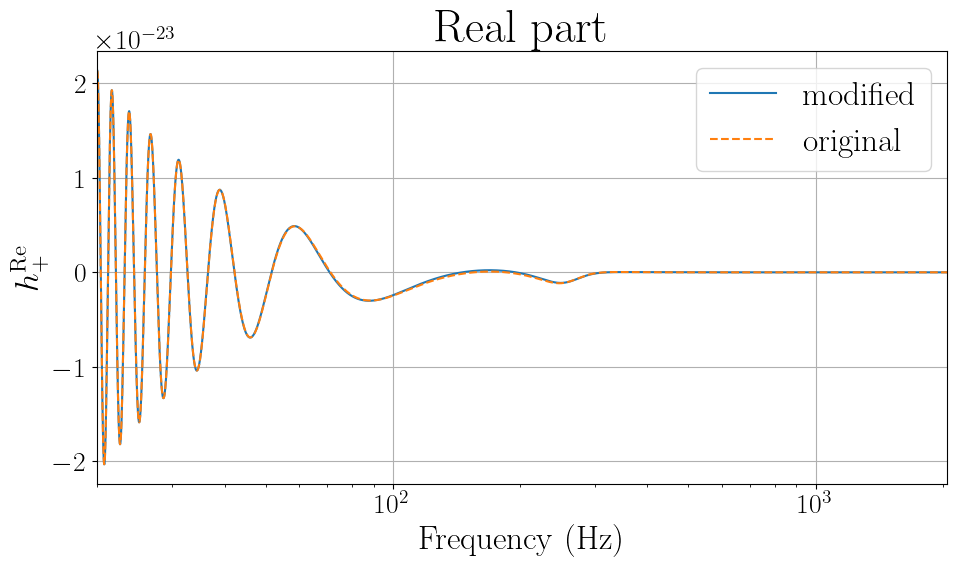

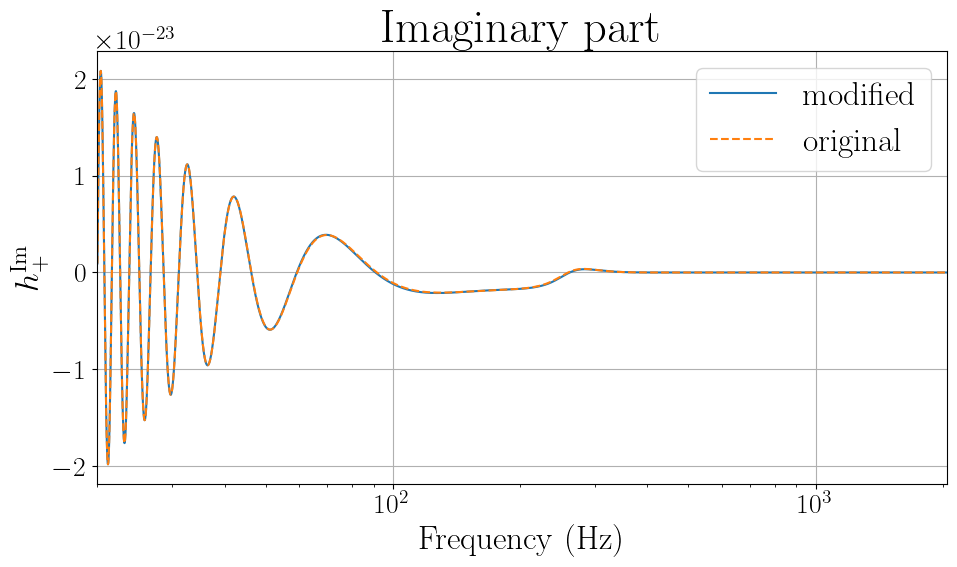

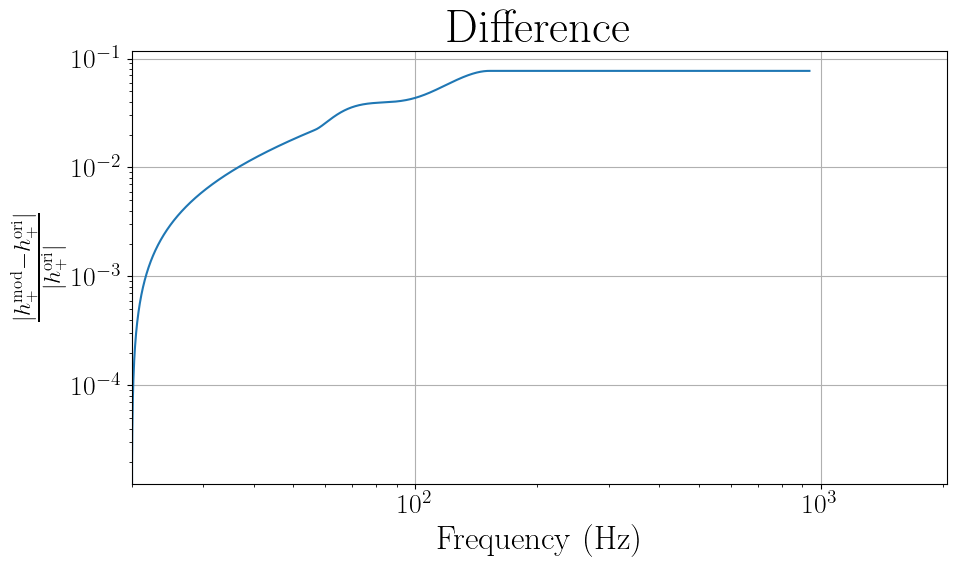

In [5]:
# fmt: off
fig, ax = plt.subplots()
ax.set_title("Real part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy["hplus"].real, label="modified")
ax.semilogx(freqs, xas_original.waveform_container_numpy["hplus"].real, linestyle="dashed", label="original")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Re}$")
ax.legend()
fig.tight_layout()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Imaginary part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy["hplus"].imag, label="modified")
ax.semilogx(freqs, xas_original.waveform_container_numpy["hplus"].imag, linestyle="dashed", label="original")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Im}$")
ax.legend()
fig.tight_layout()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Difference")
ax.loglog(freqs, np.abs(xas_modified.waveform_container_numpy["hplus"] - xas_original.waveform_container_numpy["hplus"])/np.abs(xas_original.waveform_container_numpy["hplus"]))
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$\frac{|h_+^{\rm mod} - h_+^{\rm ori}|}{|h_+^{\rm ori}|}$")
fig.tight_layout()
fig.show()
# fmt: on

## 2. Validate the modification by comparing with NRHybSur3dq8

To validate the modification mentioned above, we compare the modified waveform with the `NRHybSur3dq8` following Fig. 18 in [2001.11412](https://arxiv.org/pdf/2001.11412).

- **Roughly estimating the needed duration of time-domain waveform**

Here, we use the 0PN relation for the frequency and the time to coalescence given in 
Eq. 4.19 of *Gravitational Waves, Volume 1, Michele Maggiore*
$$
f(\tau) = \frac{1}{\pi} \left(\frac{5}{256}\frac{1}{\tau}\right) \mathcal{M}_c^{-5/8}
$$
to make the estimation. 

Considering the above relation is the 0PN approximation and do not include the effect of spins, although we consider the minimum frequency of 20 Hz here, to make sure the tapering is ended before the signal evolving into the considered band, we use 5 Hz to intensional overestimate the time to coalescence.

In [6]:
def frequency_at_time(tau, chirp_mass):
    # tau: time to coalescence, in seconds
    # chirp_mass: in unit of solar mass
    Mchirp_sec = chirp_mass * lal.MTSUN_SI
    return 1 / np.pi * (5 / 256 / tau) ** (3 / 8) * Mchirp_sec ** (-5 / 8)


def time_at_frequency(frequency, chirp_mass):
    # frequency: in Hz
    # chirp_mass: in solar mass
    Mchirp_sec = chirp_mass * lal.MTSUN_SI
    return 5 / 256 * Mchirp_sec ** (-5 / 3) * (np.pi * frequency) ** (-8 / 3)

In [7]:
taper_fraction = 0.1
fmin_redundancy = 5.0

chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(
    parameters["mass_1"], parameters["mass_2"]
)
time_at_fmin = time_at_frequency(fmin_redundancy, chirp_mass)
taper_time = time_at_fmin * taper_fraction
duration_safe = np.maximum((time_at_fmin + taper_time), 32.0)
fstart_safe = frequency_at_time(duration_safe, chirp_mass)

- Generating TD waveform

In [8]:
appro_NRHybSur3dq8 = lalsim.GetApproximantFromString("NRHybSur3dq8")
extra_params = lal.CreateDict()
mode_array_lal = lalsim.SimInspiralCreateModeArray()
lalsim.SimInspiralModeArrayActivateMode(mode_array_lal, 2, 2)
lalsim.SimInspiralWaveformParamsInsertModeArray(extra_params, mode_array_lal)

longitude_ascending_nodes = 0.0
eccentricity = 0.0
mean_per_ano = 0.0
plus_nrhyb, _ = lalsim.SimInspiralChooseTDWaveform(
    float(parameters["mass_1"] * lal.MSUN_SI),
    float(parameters["mass_2"] * lal.MSUN_SI),
    float(0.0),
    float(0.0),
    float(parameters["chi_1"]),
    float(0.0),
    float(0.0),
    float(parameters["chi_2"]),
    float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
    float(parameters["inclination"]),
    float(parameters["reference_phase"]),
    float(longitude_ascending_nodes),
    float(eccentricity),
    float(mean_per_ano),
    float(delta_time),
    float(fstart_safe),
    float(reference_frequency),
    extra_params,
    appro_NRHybSur3dq8,
)

- Tapering the waveform at the begining to suppress the Gibbs phenomenon

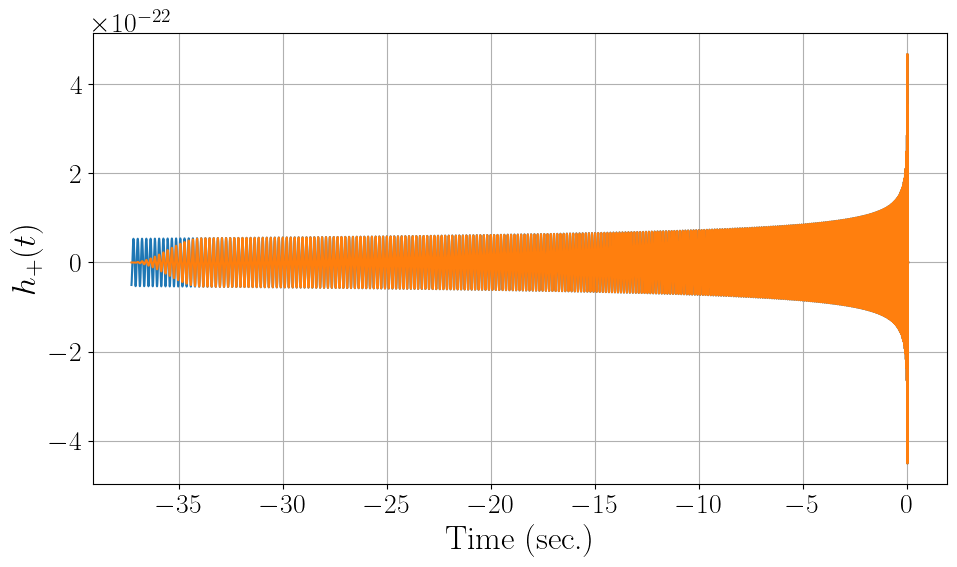

In [9]:
full_length = plus_nrhyb.data.length
t0 = float(plus_nrhyb.epoch)
time_array = np.arange(t0, t0 + full_length * delta_time, delta_time)

taper_width = int(np.floor(taper_time / delta_time))
one_width = full_length - taper_width
window = np.hanning(int(taper_width * 2))
window = np.append(window[0:taper_width], np.ones(one_width))

plus_nrhyb_tapered = plus_nrhyb.data.data * window

fig, ax = plt.subplots()
ax.plot(time_array, plus_nrhyb.data.data)
ax.plot(time_array, plus_nrhyb_tapered)
ax.set_xlabel("Time (sec.)")
ax.set_ylabel(r"$h_+(t)$")
fig.tight_layout()
fig.show()

- Performing FFT

In [10]:
plus_nrhyb_fd = np.fft.rfft(plus_nrhyb_tapered)
freq_fft = np.fft.rfftfreq(full_length, delta_time)
plus_nrhyb_fd = plus_nrhyb_fd * np.exp(-1j * 2 * np.pi * freq_fft * t0)

plus_nrhyb_fd_interp = np.interp(freqs, freq_fft, plus_nrhyb_fd)
plus_nrhyb_fd_interp *= delta_time

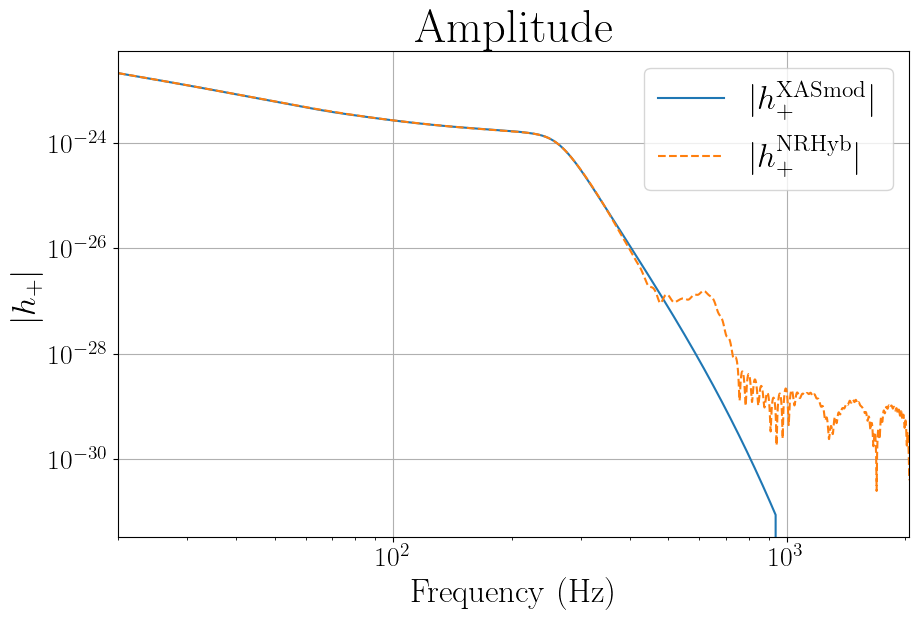

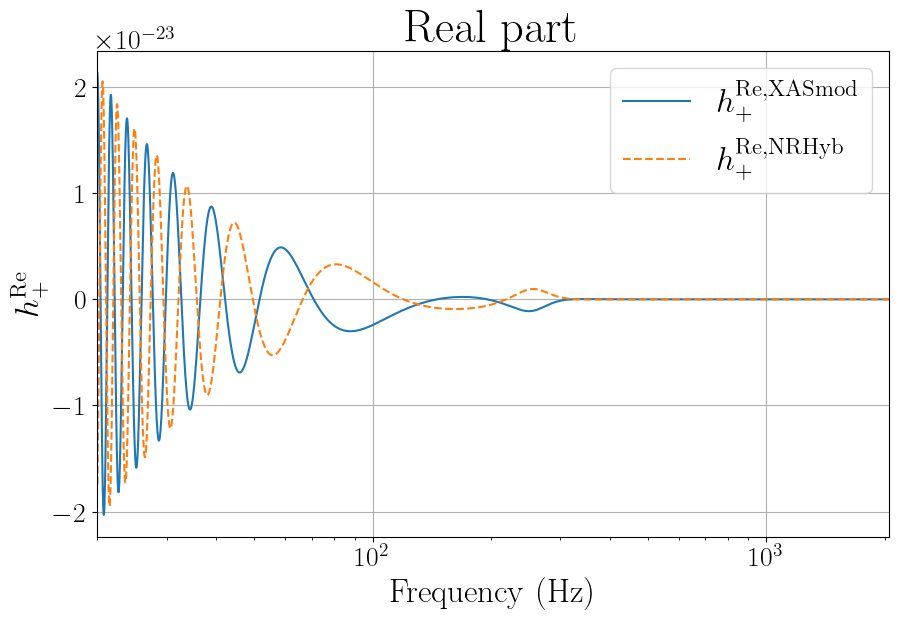

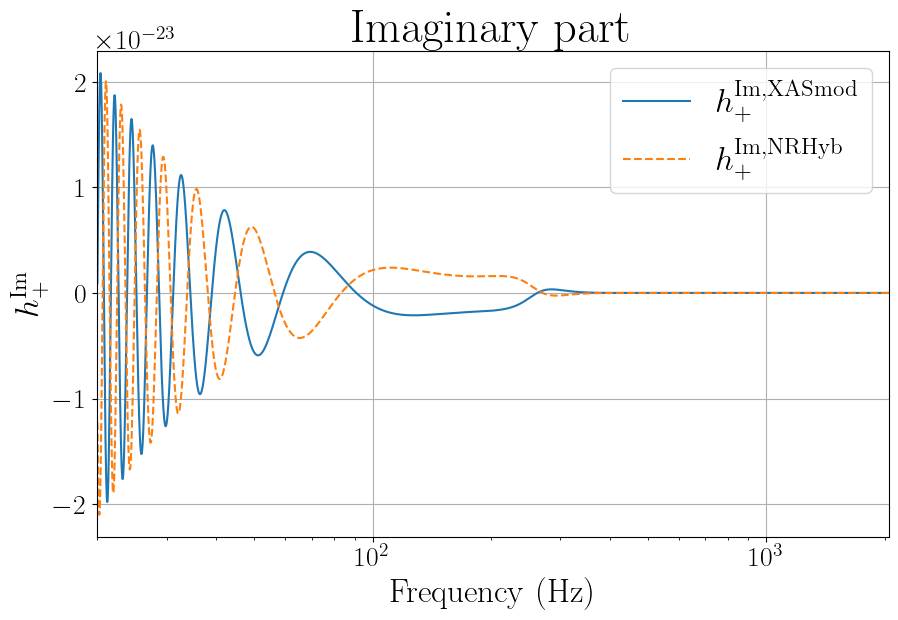

In [11]:
# fmt: off
fig, ax = plt.subplots()
ax.set_title("Amplitude")
ax.loglog(freqs, np.abs(xas_modified.waveform_container_numpy['hplus']), label=r"$|h_+^{\rm XASmod}|$")
ax.loglog(freqs, np.abs(plus_nrhyb_fd_interp), linestyle='dashed', label=r"$|h_+^{\rm NRHyb}|$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$|h_+|$")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Real part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy['hplus'].real, label=r"$h_+^{\rm Re, XASmod}$")
ax.semilogx(freqs, plus_nrhyb_fd_interp.real, linestyle='dashed', label=r"$h_+^{\rm Re, NRHyb}$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Re}$")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Imaginary part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy['hplus'].imag, label=r"$h_+^{\rm Im, XASmod}$")
ax.semilogx(freqs, plus_nrhyb_fd_interp.imag, linestyle='dashed', label=r"$h_+^{\rm Im, NRHyb}$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Im}$")
ax.legend()
fig.show()
# fmt: on

- Aligning two waveforms

In [12]:
def normalising(hf, psd_array, delta_f):
    return hf / np.sqrt(
        bilby.gw.utils.noise_weighted_inner_product(hf, hf, psd_array, 1 / delta_f).real
    )


def mismatch(h1_norm, h2_norm, psd_array, delta_f):
    return (
        1
        - bilby.gw.utils.noise_weighted_inner_product(
            h1_norm, h2_norm, psd_array, 1 / delta_f
        ).real
    )


def mismatch_with_time_phase_shift(time_phase_shift, h1_norm, h2_norm):
    shift = 1j * (2 * np.pi * freqs * time_phase_shift[0] + time_phase_shift[1])
    h1_norm_shifted = h1_norm * np.exp(shift)
    return mismatch(h1_norm_shifted, h2_norm, psd_array, delta_freq)

In [13]:
opt_res = scipy.optimize.dual_annealing(
    mismatch_with_time_phase_shift,
    bounds=((-0.1, 0.1), (-np.pi, np.pi)),
    args=(plus_nrhyb_fd_interp, xas_modified.waveform_container_numpy["hplus"]),
)
print(opt_res)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -2003.5172818125127
       x: [ 1.814e-04  2.557e+00]
     nit: 1000
    nfev: 4178
    njev: 59
    nhev: 0


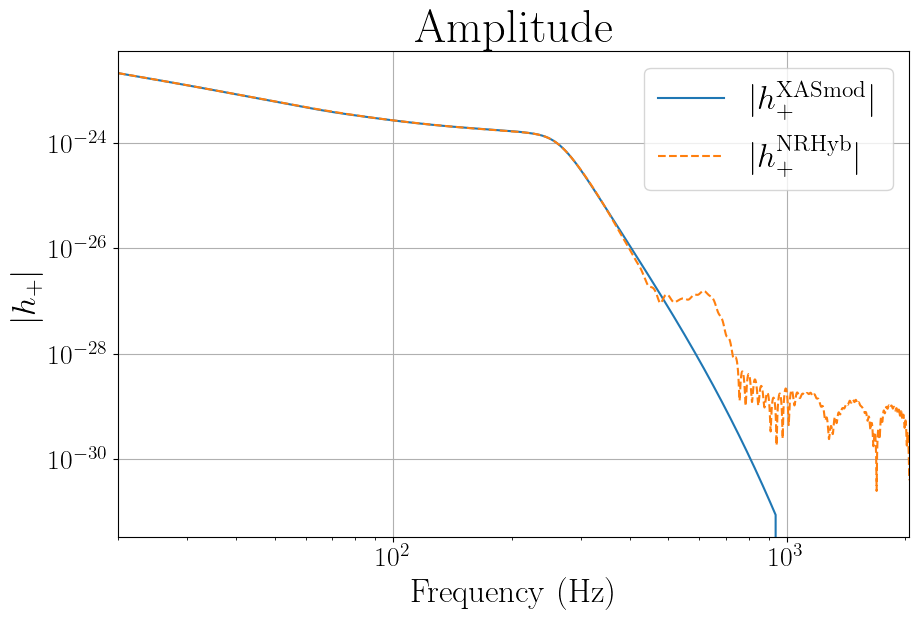

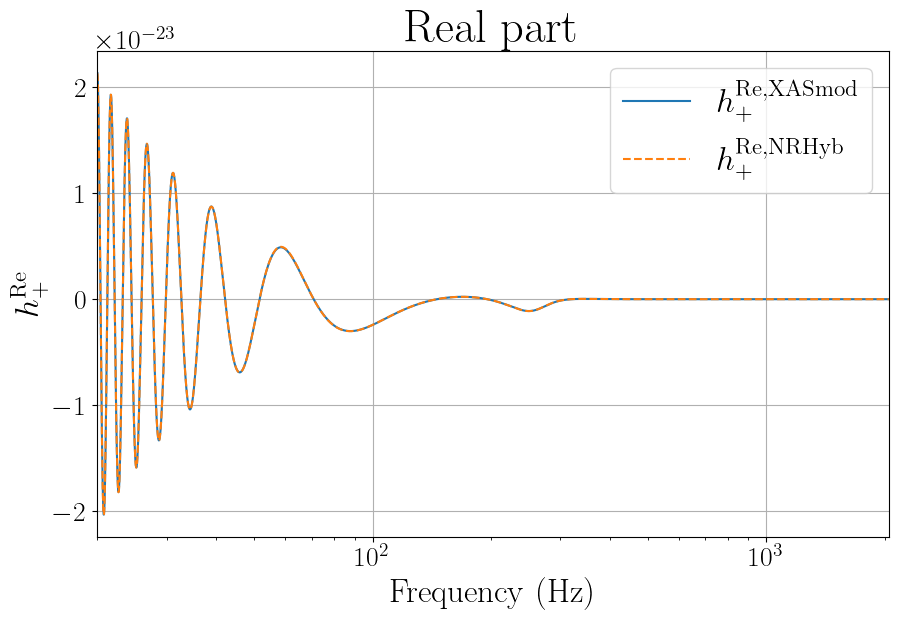

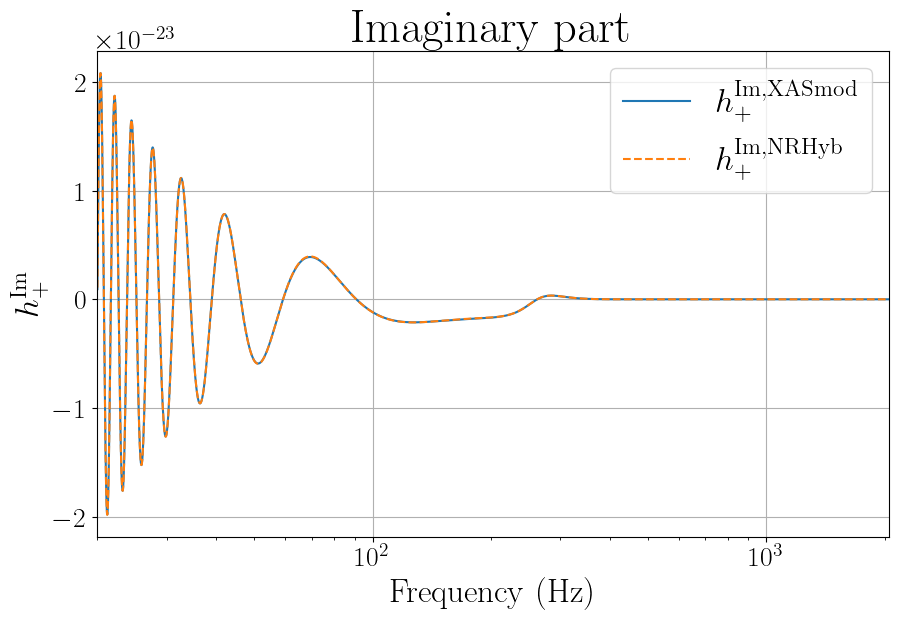

In [14]:
shift = 1j * (2 * np.pi * freqs * opt_res.x[0] + opt_res.x[1])
plus_nrhub_aligned = plus_nrhyb_fd_interp * np.exp(shift)

# fmt: off
fig, ax = plt.subplots()
ax.set_title("Amplitude")
ax.loglog(freqs, np.abs(xas_modified.waveform_container_numpy['hplus']), label=r"$|h_+^{\rm XASmod}|$")
ax.loglog(freqs, np.abs(plus_nrhub_aligned), linestyle='dashed', label=r"$|h_+^{\rm NRHyb}|$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$|h_+|$")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Real part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy['hplus'].real, label=r"$h_+^{\rm Re, XASmod}$")
ax.semilogx(freqs, plus_nrhub_aligned.real, linestyle='dashed', label=r"$h_+^{\rm Re, NRHyb}$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Re}$")
ax.legend()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Imaginary part")
ax.semilogx(freqs, xas_modified.waveform_container_numpy['hplus'].imag, label=r"$h_+^{\rm Im, XASmod}$")
ax.semilogx(freqs, plus_nrhub_aligned.imag, linestyle='dashed', label=r"$h_+^{\rm Im, NRHyb}$")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$h_+^{\rm Im}$")
ax.legend()
fig.show()
# fmt: on

- Evaluating the mismatch over the parameter space

In [15]:
def minimized_mismatch(h1, h2):
    h1_norm = normalising(h1, psd_array, delta_freq)
    h2_norm = normalising(h2, psd_array, delta_freq)

    min_res = scipy.optimize.dual_annealing(
        mismatch_with_time_phase_shift,
        bounds=((-0.1, 0.1), (-np.pi, np.pi)),
        args=(h1_norm, h2_norm),
    )
    if min_res.success:
        return min_res.fun
    else:
        raise ValueError("minimizing func exited fail")

In [16]:
num = 1000
samples = {}
rng = np.random.default_rng(20250312)
samples["total_mass"] = rng.uniform(20, 250, num)
samples["mass_ratio"] = rng.uniform(0.125, 1.0, num)
samples["chi_1"] = rng.uniform(-0.8, 0.8, num)
samples["chi_2"] = rng.uniform(-0.8, 0.8, num)
samples = bilby.gw.conversion.generate_mass_parameters(samples)


def xas_mod_wrapper(mass_1, mass_2, chi_1, chi_2):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": parameters["luminosity_distance"],
        "inclination": parameters["inclination"],
        "reference_phase": parameters["luminosity_distance"],
    }
    xas_modified.update_waveform(params_in)
    return xas_modified.waveform_container_numpy["hplus"]


def nrhyb_wrapper(mass_1, mass_2, chi_1, chi_2):
    chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)
    time_at_fmin = time_at_frequency(fmin_redundancy, chirp_mass)
    taper_time = time_at_fmin * taper_fraction
    duration_safe = np.maximum((time_at_fmin + taper_time), 32.0)
    fstart_safe = frequency_at_time(duration_safe, chirp_mass)

    plus_nrhyb, _ = lalsim.SimInspiralChooseTDWaveform(
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
        float(parameters["inclination"]),
        float(parameters["reference_phase"]),
        float(longitude_ascending_nodes),
        float(eccentricity),
        float(mean_per_ano),
        float(delta_time),
        float(fstart_safe),
        float(reference_frequency),
        extra_params,
        appro_NRHybSur3dq8,
    )

    full_length = plus_nrhyb.data.length
    t0 = float(plus_nrhyb.epoch)

    taper_width = int(np.floor(taper_time / delta_time))
    one_width = full_length - taper_width
    window = np.hanning(int(taper_width * 2))
    window = np.append(window[0:taper_width], np.ones(one_width))
    plus_nrhyb_tapered = plus_nrhyb.data.data * window

    plus_nrhyb_fd = np.fft.rfft(plus_nrhyb_tapered)
    freq_fft = np.fft.rfftfreq(full_length, delta_time)
    plus_nrhyb_fd = plus_nrhyb_fd * np.exp(-1j * 2 * np.pi * freq_fft * t0)

    plus_nrhyb_fd_interp = np.interp(freqs, freq_fft, plus_nrhyb_fd)
    plus_nrhyb_fd_interp *= delta_time

    return plus_nrhyb_fd_interp

In [17]:
# note this may consume few GB memory
wf_xas_mod_samples = list(
    map(
        xas_mod_wrapper,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
    )
)
wf_nrhyb_samples = list(
    map(
        nrhyb_wrapper,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
    )
)
wf_xas_mod_nrhyb_zip = np.stack([wf_xas_mod_samples, wf_nrhyb_samples], axis=1)
print(wf_xas_mod_nrhyb_zip.shape)

(1000, 2, 64897)


In [18]:
from multiprocessing import Pool

nproc = 72

with Pool(processes=nproc) as pool:
    mism_xas_mod = list(pool.starmap(minimized_mismatch, wf_xas_mod_nrhyb_zip))
mism_xas_mod = np.array(mism_xas_mod)

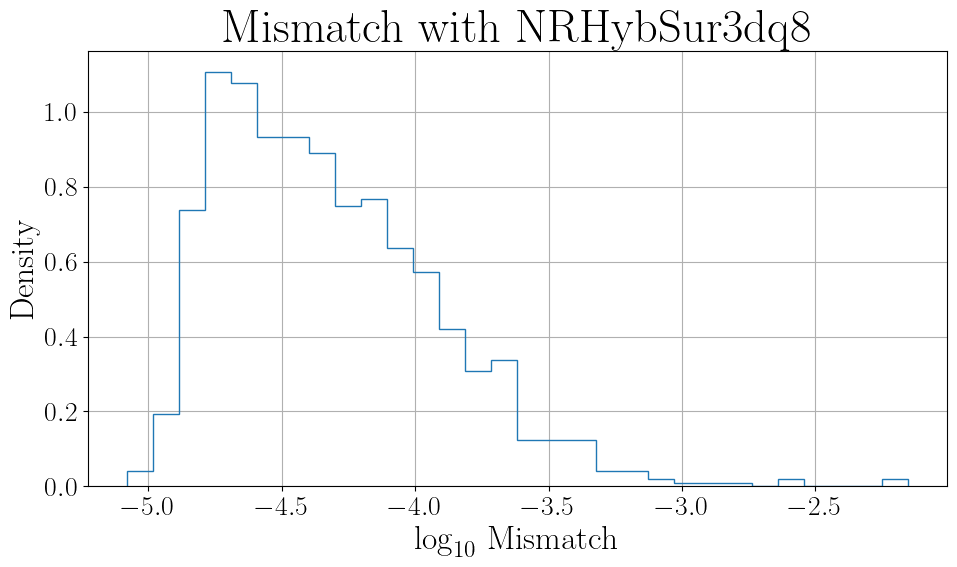

In [19]:
fig, ax = plt.subplots()
ax.set_title("Mismatch with NRHybSur3dq8")
ax.hist(
    np.log10(mism_xas_mod),
    density=True,
    bins=30,
    histtype="step",
)
ax.set_xlabel(r"$\log_{10}\, \rm Mismatch$")
ax.set_ylabel("Density")
fig.tight_layout()
fig.show()

- Comparing with the PhenomD model and the original PhenomXAS model

In [20]:
appro_xas = lalsim.GetApproximantFromString("IMRPhenomXAS")
appro_d = lalsim.GetApproximantFromString("IMRPhenomD")

freqs_lal = lal.CreateREAL8Vector(len(freqs))
freqs_lal.data = freqs


def xas_lal_wrapper(mass_1, mass_2, chi_1, chi_2):
    hp, _ = lalsim.SimInspiralChooseFDWaveformSequence(
        float(parameters["reference_phase"]),
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(reference_frequency),
        float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
        float(parameters["inclination"]),
        extra_params,
        appro_xas,
        freqs_lal,
    )
    return hp.data.data


def d_lal_wrapper(mass_1, mass_2, chi_1, chi_2):
    hp, _ = lalsim.SimInspiralChooseFDWaveformSequence(
        float(parameters["reference_phase"]),
        float(mass_1 * lal.MSUN_SI),
        float(mass_2 * lal.MSUN_SI),
        float(0.0),
        float(0.0),
        float(chi_1),
        float(0.0),
        float(0.0),
        float(chi_2),
        float(reference_frequency),
        float(parameters["luminosity_distance"] * 1e6 * lal.PC_SI),
        float(parameters["inclination"]),
        extra_params,
        appro_d,
        freqs_lal,
    )
    return hp.data.data

In [21]:
# note this may consume few GB memory
wf_xas_lal_samples = list(
    map(
        xas_lal_wrapper,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
    )
)
wf_d_lal_samples = list(
    map(
        d_lal_wrapper,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
    )
)
wf_xas_lal_nrhyb_zip = np.stack([wf_xas_lal_samples, wf_nrhyb_samples], axis=1)
wf_d_lal_nrhyb_zip = np.stack([wf_d_lal_samples, wf_nrhyb_samples], axis=1)
print(wf_xas_lal_nrhyb_zip.shape)
print(wf_d_lal_nrhyb_zip.shape)

(1000, 2, 64897)
(1000, 2, 64897)


In [22]:
with Pool(processes=nproc) as pool:
    mism_xas_lal = list(pool.starmap(minimized_mismatch, wf_xas_lal_nrhyb_zip))
    mism_d_lal = list(pool.starmap(minimized_mismatch, wf_d_lal_nrhyb_zip))
mism_xas_lal = np.array(mism_xas_lal)
mism_d_lal = np.array(mism_d_lal)

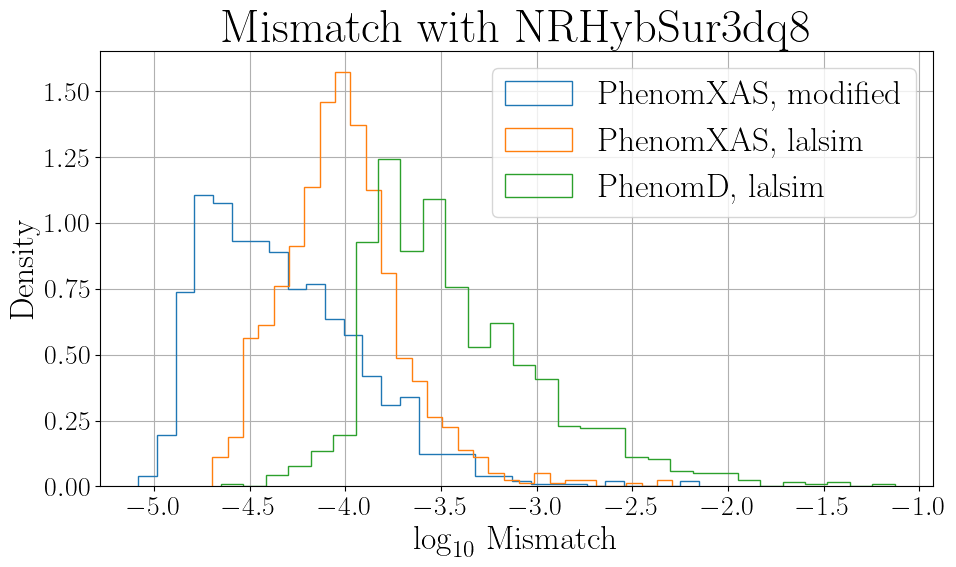

In [23]:
fig, ax = plt.subplots()
ax.set_title("Mismatch with NRHybSur3dq8")
ax.hist(
    np.log10(mism_xas_mod),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomXAS, modified",
)
ax.hist(
    np.log10(mism_xas_lal),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomXAS, lalsim",
)
ax.hist(
    np.log10(mism_d_lal),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomD, lalsim",
)
ax.set_xlabel(r"$\log_{10}\, \rm Mismatch$")
ax.set_ylabel("Density")
ax.legend()
fig.tight_layout()
fig.show()

## 3. The ansatz of intermediate amplitude

For the second modification, we try to rigidly use the ansatz of intermediate amplitude given by Eq. 6.6 in [2001.11412](https://arxiv.org/pdf/2001.11412) as
$$
A_{\rm Int} = \frac{f^{-7/6}}{\alpha_0 + \alpha_1 f + \alpha_2 f^2 + \alpha_3 f^3 + \alpha_4 f^4}.
$$ (int_amp_1)

Here for explicit, we use a different notation from [2001.11412](https://arxiv.org/pdf/2001.11412), where the frequency-independent constant in $A_0$ is omitted, and the common term of $f^{-7/6}$ is separated out of the $A_{\rm Ins}$ and $A_{\rm MRD}$ in below. The 5 ansatz coefficients are determined through the linear system
$$
\begin{aligned}
A_{\rm Int}(f_0) &= f_0^{-7/6} A_{\rm Ins}(f_0), \\
A_{\rm Int}(f_1) &= A_{\rm fit}(f_1), \\
A_{\rm Int}(f_2) &= f_2^{-7/6} A_{\rm MRD}(f_2), \\
A'_{\rm Int}(f_0) &= [f_0^{-7/6} A_{\rm Ins}(f_0)]', \\
A'_{\rm Int}(f_2) &= [f_0^{-7/6} A_{\rm MRD}(f_2)]'. \\
\end{aligned}
$$ 
(Note the fitted value has already incorporated the $f^{-7/6}$ factor ([l.904](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L904)), so we do not write it out.)

In `lalsimulation`, the factor of $f^{-7/6}$ is absorbed into the ansatz coefficients (see [l.842](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L842) to [l.935](https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimIMRPhenomX_internals.c#L935) in `LALSimIMRPhenomX_internals.c`). Therefore, the linear system can be written explicitly as 
$$
\begin{bmatrix}
\begin{aligned}
&1 \quad &f_0 \quad &f_0^2 \quad &f_0^3 \quad &f_0^4 \\
&1 \quad &f_1 \quad &f_1^2 \quad &f_1^3 \quad &f_1^4 \\
&1 \quad &f_2 \quad &f_2^2 \quad &f_2^3 \quad &f_2^4 \\
&0 \quad &1   \quad &2f_0  \quad &3f_0^2\quad &4f_0^3 \\
&0 \quad &1   \quad &2f_2  \quad &3f_2^2\quad &4f_2^3 \\
\end{aligned}
\end{bmatrix}
\begin{bmatrix}
\begin{aligned}
\alpha_0 {\color{red} f_{??}^{7/6}}\\
\alpha_1 {\color{red} f_{??}^{7/6}}\\
\alpha_2 {\color{red} f_{??}^{7/6}}\\
\alpha_3 {\color{red} f_{??}^{7/6}}\\
\alpha_4 {\color{red} f_{??}^{7/6}}\\
\end{aligned}
\end{bmatrix}=
\begin{bmatrix}
\begin{aligned}
f_0^{7/6}/A_{\rm Ins}(f_0)  \\
        1/A_{\rm fit}(f_1)  \\
f_2^{7/6}/A_{\rm MRD}(f_2)  \\
\frac{7/6 f_0^{1/6}}{A_{\rm Ins}(f_0)} - \frac{f_0^{7/6} A'_{\rm Ins}(f_0)}{A^2_{\rm Ins}(f_0)} \\
\frac{7/6 f_2^{1/6}}{A_{\rm MRD}(f_2)} - \frac{f_2^{7/6} A'_{\rm MRD}(f_2)}{A^2_{\rm MRD}(f_2)} \\
\end{aligned}
\end{bmatrix}.
$$
But this seems to have a problem. Absorbing a frequency-dependent factor into the ansatz coefficients makes them no longer constant. Or it can be viewed as using the ansatz with the form of
$$
A_{\rm Int} = \frac{1}{\alpha_0 + \alpha_1 f + \alpha_2 f^2 + \alpha_3 f^3 + \alpha_4 f^4}.
$$ (int_amp_2)

To confirm whether the ansatz of Eq. 6.6 in [2001.11412](https://arxiv.org/pdf/2001.11412) includes the $f^{-7/6}$ unintentionally, and if this form of ansatz can be better, We make a slight modification in the intermediate amlitude as below.

First we can get rid of the factor $f^{-7/6}$ through a simple simplification. We only write down the first node here, the situation of third node is similar. For the equation of the original ansatz, we can simply have
$$
\begin{aligned}
\frac{f_0^{-7/6}}{[...]_{f_0}} &= f_0^{-7/6} A_{\mathrm{ins}}(f_0),\\
[...]_{f_0} &= 1/A_{\mathrm{ins}}(f_0).
\end{aligned}
$$
For the equation of derivative ansatz,
$$
\begin{aligned}
\left[\frac{f_0^{-7/6}}{[...]_{f_0}}\right]' &= \left[f_0^{-7/6} A_{\mathrm{ins}}(f_0)\right]', \\
\frac{-7/6 f_0^{-13/6}[...]_{f_0} - f_0^{-7/6} [...]_{f_0}' }{[...]^2_{f_0}} &= -7/6 f_0^{-13/6}A_{\mathrm{ins}}(f_0) + f_0^{-7/6} A'_{\mathrm{ins}}(f_0)\\
\end{aligned}
$$
With $[...]_{f_0} = 1/A_{\mathrm{ins}}(f_0)$, we can obtain
$$
[...]_{f_0}' = - \frac{A'_{\mathrm{ins}}(f_0)}{A_{\mathrm{ins}}^{2}(f_0)}
$$

<!-- ]} &= A_0(f_1)A_{\mathrm{ins}}(f_1),\\
A_{\mathrm{int}}^{\mathrm{inv}}(f_1) &= 1/A_{\mathrm{ins}}(f_1),
\end{aligned}
$$
$$
\begin{aligned}
\left[\frac{A_0(f_1)}{A_{\mathrm{int}}^{\mathrm{inv}}(f_1)}\right]' &= \left[A_0(f_1)A_{\mathrm{ins}}(f_1)\right]', \\
\left[A_{\mathrm{int}}^{\mathrm{inv}}(f_1)\right]' &= \frac{A'_{\mathrm{ins}}(f_1)}{A_{\mathrm{ins}}^{2}(f_1)}
\end{aligned}
$$ -->

In [24]:
from tiwave.waveforms.IMRPhenomXAS import AmplitudeCoefficients


@sub_struct_from(AmplitudeCoefficients)
class AmplitudeCoefficientsModified:

    @ti.func
    def _set_intermediate_coefficients(
        self, pn_coefficients: ti.template(), source_params: ti.template()
    ):
        """
        Only the recommended fit model `104` is implemented, and only can be called after
        updated the inspiral and merge-ringdown coefficients.
        """
        # rigidly follow Eq. 6.6 in 2001.11412 (including f^(-7/6))
        # different with lalsim
        # if this part is used to get the intermediate amplitude coefficients, the
        # _compute_amplitdue() must be modified accordingly.
        self.int_colloc_values[0] = 1.0 / self._inspiral_amplitude(
            pn_coefficients, self._useful_powers.fjoin_int_ins
        )
        self.int_colloc_values[1] = self.int_colloc_points[1] ** (-7 / 6) / (
            (
                1.4873184918202145
                + 1974.6112656679577 * source_params.eta
                + 27563.641024162127 * source_params.eta_pow2
                - 19837.908020966777 * source_params.eta_pow3
            )
            / (
                1.0
                + 143.29004876335128 * source_params.eta
                + 458.4097306093354 * source_params.eta_pow2
            )
            + source_params.S_tot_hat
            * (
                27.952730865904343
                + source_params.eta
                * (-365.55631765202895 - 260.3494489873286 * source_params.S_tot_hat)
                + 3.2646808851249016 * source_params.S_tot_hat
                + 3011.446602208493 * source_params.eta_pow2 * source_params.S_tot_hat
                - 19.38970173389662 * source_params.S_tot_hat_pow2
                + source_params.eta_pow3
                * (
                    1612.2681322644232
                    - 6962.675551371755 * source_params.S_tot_hat
                    + 1486.4658089990298 * source_params.S_tot_hat_pow2
                )
            )
            / (
                12.647425554323242
                - 10.540154508599963 * source_params.S_tot_hat
                + 1.0 * source_params.S_tot_hat_pow2
            )
            + source_params.delta_chi
            * source_params.delta
            * (-0.016404056649860943 - 296.473359655246 * source_params.eta)
            * source_params.eta_pow2
        )
        self.int_colloc_values[2] = 1.0 / self._merge_ringdown_amplitude(
            source_params, self._useful_powers.fjoin_MRD_int
        )
        self.int_colloc_values[3] = -(
            self._inspiral_d_amplitude(
                pn_coefficients, self._useful_powers.fjoin_int_ins
            )
            * self.int_colloc_values[0] ** 2
        )
        self.int_colloc_values[4] = -(
            self._merge_ringdown_d_amplitude(
                source_params, self._useful_powers.fjoin_MRD_int
            )
            * self.int_colloc_values[2] ** 2
        )

        Ab_int = ti.Matrix(
            [
                [
                    1.0,
                    self.int_colloc_points[0],
                    self.int_colloc_points[0] ** 2,
                    self.int_colloc_points[0] ** 3,
                    self.int_colloc_points[0] ** 4,
                    self.int_colloc_values[0],
                ],
                [
                    1.0,
                    self.int_colloc_points[1],
                    self.int_colloc_points[1] ** 2,
                    self.int_colloc_points[1] ** 3,
                    self.int_colloc_points[1] ** 4,
                    self.int_colloc_values[1],
                ],
                [
                    1.0,
                    self.int_colloc_points[2],
                    self.int_colloc_points[2] ** 2,
                    self.int_colloc_points[2] ** 3,
                    self.int_colloc_points[2] ** 4,
                    self.int_colloc_values[2],
                ],
                [
                    0.0,
                    1.0,
                    2.0 * self.int_colloc_points[0],
                    3.0 * self.int_colloc_points[0] ** 2,
                    4.0 * self.int_colloc_points[0] ** 3,
                    self.int_colloc_values[3],
                ],
                [
                    0.0,
                    1.0,
                    2.0 * self.int_colloc_points[2],
                    3.0 * self.int_colloc_points[2] ** 2,
                    4.0 * self.int_colloc_points[2] ** 3,
                    self.int_colloc_values[4],
                ],
            ]
        )
        (
            self.alpha_0,
            self.alpha_1,
            self.alpha_2,
            self.alpha_3,
            self.alpha_4,
        ) = gauss_elimination(Ab_int)

    @ti.func
    def compute_amplitude(
        self,
        pn_coefficients: ti.template(),
        source_params: ti.template(),
        powers_of_Mf: ti.template(),
    ) -> ti.f64:
        amplitude = 0.0
        if powers_of_Mf.one < self.fjoin_int_ins:
            amplitude = self._inspiral_amplitude(pn_coefficients, powers_of_Mf)
        elif powers_of_Mf.one > self.fjoin_MRD_int:
            amplitude = self._merge_ringdown_amplitude(source_params, powers_of_Mf)
        else:
            amplitude = self._intermediate_amplitude(powers_of_Mf)
        return (
            source_params.dimension_factor
            * self.common_factor
            * amplitude
            / powers_of_Mf.seven_sixths
        )


class IMRPhenomXASModified2(IMRPhenomXAS):

    def __init__(
        self,
        frequencies,
        reference_frequency=None,
        returned_form="polarizations",
        include_tf=True,
        check_parameters=False,
    ):
        super().__init__(
            frequencies,
            reference_frequency,
            returned_form,
            include_tf,
            check_parameters,
        )

        self.amplitude_coefficients = AmplitudeCoefficientsModified.field(shape=())

In [25]:
xas_modified_2 = IMRPhenomXASModified2(freqs_ti, reference_frequency)
xas_modified_2.update_waveform(parameters)

/home/hydrogen/workspace/Space_GW/tiwave/tiwave/waveforms/base_waveform.py:45: UserWarning: check_parameters is disable, make sure all parameters passed in are valid.
  warnings.warn(


/tmp/ipykernel_1737604/2916973792.py:15: RuntimeWarning: invalid value encountered in divide
  ax.loglog(freqs, np.abs(xas_modified_2.waveform_container_numpy["hplus"] - xas_original.waveform_container_numpy["hplus"])/np.abs(xas_original.waveform_container_numpy["hplus"]))


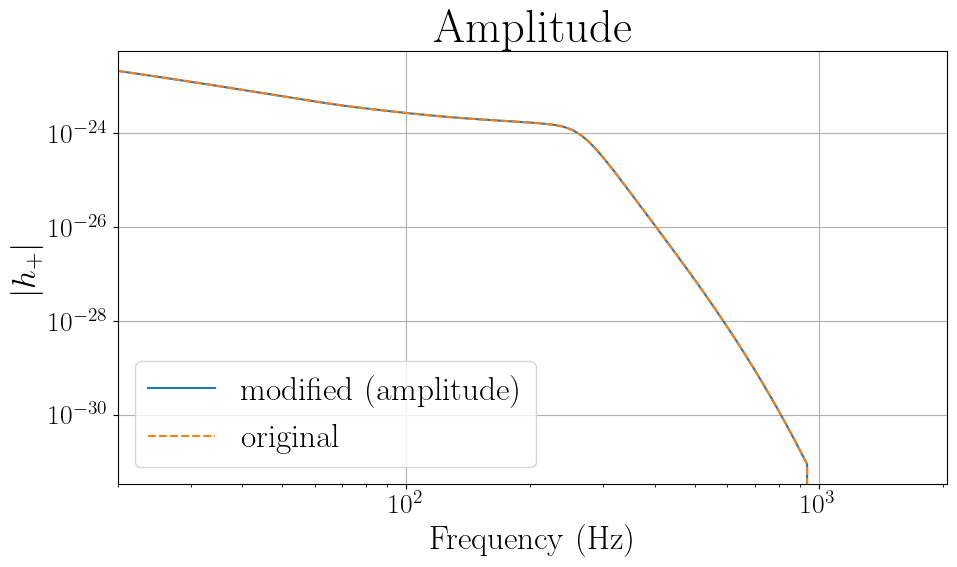

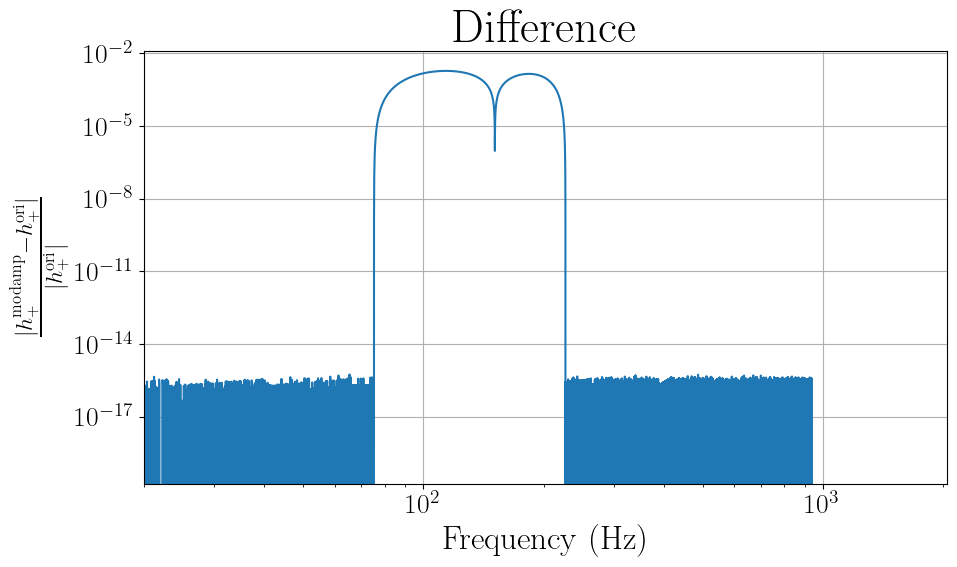

In [26]:
# fmt: off
fig, ax = plt.subplots()
ax.set_title("Amplitude")
ax.loglog(freqs, np.abs(xas_modified_2.waveform_container_numpy["hplus"]), label="modified (amplitude)")
ax.loglog(freqs, np.abs(xas_original.waveform_container_numpy["hplus"]), linestyle="dashed", label="original")
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$|h_+|$")
ax.legend()
fig.tight_layout()
fig.show()

fig, ax = plt.subplots()
ax.set_title("Difference")
ax.loglog(freqs, np.abs(xas_modified_2.waveform_container_numpy["hplus"] - xas_original.waveform_container_numpy["hplus"])/np.abs(xas_original.waveform_container_numpy["hplus"]))
ax.set_xlim(minimum_frequency, maximum_frequency)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel(r"$\frac{|h_+^{\rm mod amp} - h_+^{\rm ori}|}{|h_+^{\rm ori}|}$")
fig.tight_layout()
fig.show()
# fmt: on

In [27]:
def xas_mod2_wrapper(mass_1, mass_2, chi_1, chi_2):
    params_in = {
        "mass_1": mass_1,
        "mass_2": mass_2,
        "chi_1": chi_1,
        "chi_2": chi_2,
        "luminosity_distance": parameters["luminosity_distance"],
        "inclination": parameters["inclination"],
        "reference_phase": parameters["luminosity_distance"],
    }
    xas_modified_2.update_waveform(params_in)
    return xas_modified_2.waveform_container_numpy["hplus"]


# note this may consume few GB memory
wf_xas_mod2_samples = list(
    map(
        xas_mod2_wrapper,
        samples["mass_1"],
        samples["mass_2"],
        samples["chi_1"],
        samples["chi_2"],
    )
)
wf_xas_mod2_nrhyb_zip = np.stack([wf_xas_mod2_samples, wf_nrhyb_samples], axis=1)
print(wf_xas_mod2_nrhyb_zip.shape)

with Pool(processes=nproc) as pool:
    mism_xas_mod2 = list(pool.starmap(minimized_mismatch, wf_xas_mod2_nrhyb_zip))
mism_xas_mod2 = np.array(mism_xas_mod2)

(1000, 2, 64897)


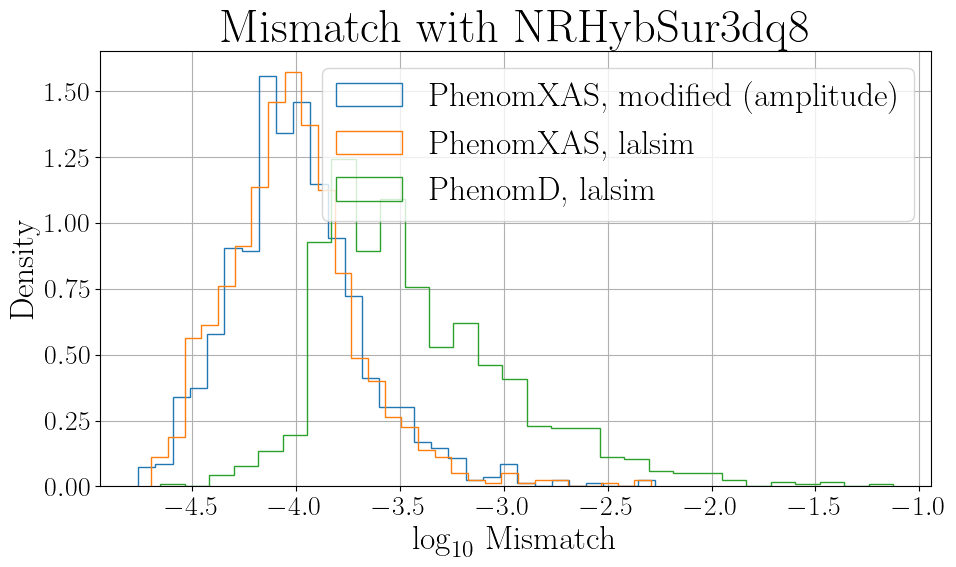

In [28]:
fig, ax = plt.subplots()
ax.set_title("Mismatch with NRHybSur3dq8")
ax.hist(
    np.log10(mism_xas_mod2),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomXAS, modified (amplitude)",
)
ax.hist(
    np.log10(mism_xas_lal),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomXAS, lalsim",
)
ax.hist(
    np.log10(mism_d_lal),
    density=True,
    bins=30,
    histtype="step",
    label="PhenomD, lalsim",
)
ax.set_xlabel(r"$\log_{10}\, \rm Mismatch$")
ax.set_ylabel("Density")
ax.legend()
fig.tight_layout()
fig.show()